# Putting refugee data from the war in Ukraine into context

*March 21, 2022*

I've been doing a lot with [UNHCR's Ukrainian refugee data](https://data2.unhcr.org/en/situations/ukraine), but I haven't done much to put it into context. I assume these are very high numbers, but would like some data to determine how high they really are. Let's look at it a few different ways.

First, we import pandas, and requests (which we use a little later to fetch the current Ukrainian crisis data using UNHCR's API).

In [2]:
import pandas as pd
import requests

raw = pd.read_csv('../raw/RAW 2022 UNHCR REFUGEES.csv', skiprows=14)

display(raw.head())

,Year,Country of origin,Country of origin (ISO),Country of asylum,Country of asylum (ISO),Refugees under UNHCR's mandate,Asylum-seekers,IDPs of concern to UNHCR,Venezuelans displaced abroad,Stateless persons,Others of concern
0,2016,Afghanistan,AFG,Afghanistan,AFG,0,0,1797551,NaN,0,114221
1,2016,Afghanistan,AFG,Egypt,EGY,14,21,0,NaN,0,0
2,2016,Afghanistan,AFG,Argentina,ARG,5,0,0,NaN,0,0
3,2016,Afghanistan,AFG,Australia,AUS,9217,2077,0,NaN,0,0
4,2016,Afghanistan,AFG,Austria,AUT,20220,29783,0,NaN,0,0


### Where did Ukraine rank in 2021 for refugees leaving?

Let's start by getting a list of all countries and how many "Refugees under UNHCR's mandate" were recorded in all years on record. It's really just a reshape and filter on the raw data.

In [3]:
origin_totals = (raw
                  .loc[:, ["Country of origin", "Year", "Refugees under UNHCR's mandate"]]
                  .pivot_table(columns="Year", index="Country of origin", aggfunc='sum')
                  .droplevel(0, axis=1)
                  .sort_values(2021, ascending=False)
                  )

display(origin_totals)

Year,2016,2017,2018,2019,2020,2021
Country of origin,,,,,,
Syrian Arab Rep.,5524511.0,6310498.0,6654374.0,6615249.0,6702912.0,6761560.0
Afghanistan,2501447.0,2624265.0,2681267.0,2727556.0,2594826.0,2610067.0
South Sudan,1436707.0,2439888.0,2285301.0,2234805.0,2188785.0,2277919.0
Myanmar,490285.0,1156742.0,1145149.0,1076825.0,1103246.0,1127588.0
Dem. Rep. of the Congo,537474.0,620805.0,720302.0,802974.0,840391.0,864510.0
...,...,...,...,...,...,...
Brunei Darussalam,0.0,0.0,NaN,0.0,0.0,0.0
Finland,5.0,5.0,5.0,0.0,NaN,NaN
Luxembourg,NaN,NaN,0.0,5.0,5.0,NaN


We also add a column for rank, which is really just a range starting from 1 applied to a dataframe that's sorted by 2021 numbers.

In [4]:
origin_totals["Rank"] = range(1, len(origin_totals) + 1)

Now we can simply grab the entry for Ukraine and print it to console.

In [5]:
ukraine_rank = origin_totals.loc["Ukraine", ["Rank", 2021]]

display(ukraine_rank)

Year
Rank       36.0
2021    30800.0
Name: Ukraine, dtype: float64

### Where would Ukraine war refugee counts rank against 2021 data for other countries?

Before we start to answer this question, let's pull in the JSON crisis data that UNHCR provides using the requests module, and put it into a dataframe. We'll use this for a few different purposes. We'll also add a total row.

In [6]:
r = (requests
     .get('https://data2.unhcr.org/population/get/sublocation?widget_id=286723&sv_id=54&population_group=5461&forcesublocation=0&fromDate=1900-01-01')
     .json()
     ["data"]
     )

crisis_refugees = (pd
        .DataFrame(r)
        .loc[:, ["geomaster_name", "individuals"]]
        .set_index("geomaster_name")
        )
crisis_refugees.loc["Total","individuals"] = crisis_refugees["individuals"].astype(int).sum()

display(crisis_refugees)

,individuals
geomaster_name,
Poland,2113554
Romania,543308
Republic of Moldova,367913
Hungary,317863
Slovakia,253592
Russian Federation,252376
Belarus,4308
Total,3852914


Because we'll use our origins table again, we'll copy it here (so we don't make up data that isn't accurate!) and insert the total value from the table above as Ukraine's entry.

In [7]:
what_if = origin_totals[[2021]].copy()

what_if.at["Ukraine", 2021] = crisis_refugees.at["Total", "individuals"]

what_if = what_if.sort_values(2021, ascending=False)

what_if["Rank"] = range(1, len(what_if) + 1)

display(what_if.head())

Year,2021,Rank
Country of origin,,
Syrian Arab Rep.,6761560.0,1
Ukraine,3852914.0,2
Afghanistan,2610067.0,3
South Sudan,2277919.0,4
Myanmar,1127588.0,5


So far, Ukraine refugees have passed Afghanistan to take the second rank in refugees from individual countries.

### How does the number of people that neighbouring countries are receiving from Ukraine compare to how many they have received in previous years from Ukraine?

 We can see that UNHCR counts seven countries as neighbours. We'll pull those into a list, which we'll use in a moment.

In [8]:
neighbouring_countries = crisis_refugees.index.unique()

Now, from our first dataset, we'll grab data from years 2016-2021 for the countries that surround Ukraine, using the list we just created.

In [9]:
ukraine_to_neighbours = (raw
                  .loc[raw["Country of asylum"].isin(neighbouring_countries), ["Country of asylum", "Year", "Refugees under UNHCR's mandate"]]
                  .pivot_table(columns="Year", index="Country of asylum", aggfunc='sum')
                  .droplevel(0, axis=1)
                  .sort_values(2021, ascending=False)
                  )

display(ukraine_to_neighbours)

Year,2016,2017,2018,2019,2020,2021
Country of asylum,,,,,,
Russian Federation,228981,126021,77382,42413,20260,15052
Hungary,4736,5671,6019,5750,5838,5736
Romania,2880,3911,4134,3860,3581,3776
Poland,11738,12225,12495,12658,2771,3166
Belarus,1647,2155,2225,2725,2900,2924
Slovakia,980,912,938,965,1006,1012


Now, let's attach the crisis data onto the end of the 2016-2021 totals to create one table where all the relevant information resides.

In [10]:
table = ukraine_to_neighbours.join(crisis_refugees).rename(columns={"individuals": "Crisis Refugees"}).astype(int)

display(table)

,2016,2017,2018,2019,2020,2021,Crisis Refugees
Country of asylum,,,,,,,
Russian Federation,228981,126021,77382,42413,20260,15052,252376
Hungary,4736,5671,6019,5750,5838,5736,317863
Romania,2880,3911,4134,3860,3581,3776,543308
Poland,11738,12225,12495,12658,2771,3166,2113554
Belarus,1647,2155,2225,2725,2900,2924,4308
Slovakia,980,912,938,965,1006,1012,253592


### The crisis vs. previous years

Lastly, let's do some comparisons. First, with some simple math.

In [11]:
total_2021 = table[2021].sum()
print(f'Refugees from Ukraine into all neighbouring countries in 2021: {total_2021}')

total_2016_to_2021 = table.loc[:, 2016:2021].sum().sum()
print(f'Refugees from Ukraine into all neighbouring countries since 2016: {total_2016_to_2021}')

crisis_refugees = table["Crisis Refugees"].sum()
print(f'Refugees from Ukraine since war began: {crisis_refugees}')

print(f'There are about {int(crisis_refugees / total_2021)} times more refugees that have sought asylum from Ukraine in countries surrounding Ukraine during the war with Russia than there were in all of 2021.')

print(f'There are about {int(crisis_refugees / total_2016_to_2021)} times more refugees that have sought asylum from Ukraine in countries surrounding Ukraine during the war with Russia than there have been since 2016.')

Refugees from Ukraine into all neighbouring countries in 2021: 31666
Refugees from Ukraine into all neighbouring countries since 2016: 641443
Refugees from Ukraine since war began: 3485001
There are about 110 times more refugees that have sought asylum from Ukraine in countries surrounding Ukraine during the war with Russia than there were in all of 2021.
There are about 5 times more refugees that have sought asylum from Ukraine in countries surrounding Ukraine during the war with Russia than there have been since 2016.


Next, let's get some calculations by country. We'll divide the change in volume between the 2016-2021 sum for each country and the crisis number by the 2016-2021 sum for each country to get a % increase.

In [12]:
table["Crisis Refugees (% change)"] = ((table["Crisis Refugees"] - table.loc[:, 2016:2021].sum(axis=1)) / table.loc[:, 2016:2021].sum(axis=1)) * 100

display(table)

,2016,2017,2018,2019,2020,2021,Crisis Refugees,Crisis Refugees (% change)
Country of asylum,,,,,,,,
Russian Federation,228981,126021,77382,42413,20260,15052,252376,-50.525084
Hungary,4736,5671,6019,5750,5838,5736,317863,841.816296
Romania,2880,3911,4134,3860,3581,3776,543308,2353.744016
Poland,11738,12225,12495,12658,2771,3166,2113554,3739.125933
Belarus,1647,2155,2225,2725,2900,2924,4308,-70.444566
Slovakia,980,912,938,965,1006,1012,253592,4262.497850


It looks like there have been fewer refugees going to Belarus and Russia (not surprising) than the last 6 years combined, but far more into the other countries than those 6 years combined.

### Refugees over time

I found some new data, so I'm adding to this notebook retroactively. [This dataset](https://docs.google.com/spreadsheets/d/1bXLjWwcF8Mlj5v06GFpdCvBMl3i1hUuCnXeMdlI9W_Q/edit#gid=0) is the same as the daily snapshot, but it provides data going back to the start of the war. Let's get into it.

In [13]:
over_time_raw = pd.read_csv('../raw/RAW 2022 UNHCR REFUGEES OVER TIME.csv')

display(over_time_raw)

,Data Geomaster Name,Data Admin Level,2022-03-01,2022-03-02,2022-03-03,2022-03-04,2022-03-05,2022-03-06,2022-03-07,2022-03-08,...,2022-03-12,2022-03-13,2022-03-14,2022-03-15,2022-03-16,2022-03-17,2022-03-18,2022-03-19,2022-03-20,2022-03-21
0,Poland,Country,-,547982,649903,756303,885303,1027603,-,1412503,...,1655503.0,1720227.0,NaN,1857045,1916445,-,2010693,2050392,2083854,2113554
1,Hungary,Country,-,133009,144738,157004,169053,180163,191348,214160,...,246206.0,255291.0,263888.0,272943,282611,291230,299273,305518,312120,317863
2,Republic of Moldova,Country,-,97827,103254,-,84067,82762,-,-,...,NaN,106994.0,337215.0,344454,350886,355426,359056,362514,365197,367913
3,Slovakia,Country,-,72200,90329,101529,113967,128169,140745,-,...,195980.0,204862.0,213000.0,220977,228844,234738,240009,245569,250036,253592
4,Romania,Country,-,51261,57192,63192,71640,78977,-,84671,...,NaN,NaN,453432.0,467703,491409,508692,518269,527247,535461,543308
5,Russian Federation,Country,-,47800,53300,-,-,-,-,99300,...,NaN,131365.0,142994.0,155841,168858,184563,-,-,231764,252376
6,Belarus,Country,357,357,384,406,-,-,453,-,...,NaN,1226.0,1475.0,1816,2127,2548,-,-,3765,4308


All I really want to do before getting this into Datawrapper is to transpose it and clean it up a little.

In [17]:
transposed = over_time_raw.transpose()

transposed.columns = transposed.loc["Data Geomaster Name", :]

transposed = (transposed
              .drop(["Data Geomaster Name", "Data Admin Level"])
              .replace("-", pd.NA)
              .ffill()
              .dropna()
              .astype(int)
              )

display(transposed)

Data Geomaster Name,Poland,Hungary,Republic of Moldova,Slovakia,Romania,Russian Federation,Belarus
2022-03-02,547982,133009,97827,72200,51261,47800,357
2022-03-03,649903,144738,103254,90329,57192,53300,384
2022-03-04,756303,157004,103254,101529,63192,53300,406
2022-03-05,885303,169053,84067,113967,71640,53300,406
2022-03-06,1027603,180163,82762,128169,78977,53300,406
2022-03-07,1027603,191348,82762,140745,78977,53300,453
2022-03-08,1412503,214160,82762,140745,84671,99300,453
2022-03-09,1412503,214160,82762,165199,84671,97098,765
2022-03-10,1412503,225046,104929,176092,84671,105897,858
2022-03-11,1575703,235576,104929,185673,84671,105897,938


A quick plot of this dataframe.

<AxesSubplot:>

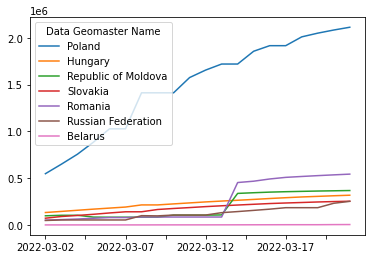

In [19]:
transposed.plot()

Here's the result in [Datawrapper](https://www.datawrapper.de/_/OJ4XP/).

\-30\-